# characterize political threads in subreddits

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index

In [2]:
df2012 = build_df_year(2012, with_text=True, with_time=True, filter_null=False)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012


In [3]:
df2012["body_len"] = df2012["body"].map(lambda x: len(x))

## aggregate by submission

In [4]:
aggr_func = {"comment_id": lambda x: list(x), "toxicity": np.mean, "body_len":np.sum}
groupby_subm = df2012.groupby("submission_id").agg(aggr_func).reset_index()
groupby_subm["n_comments"] = groupby_subm["comment_id"].map(lambda x: len(x))

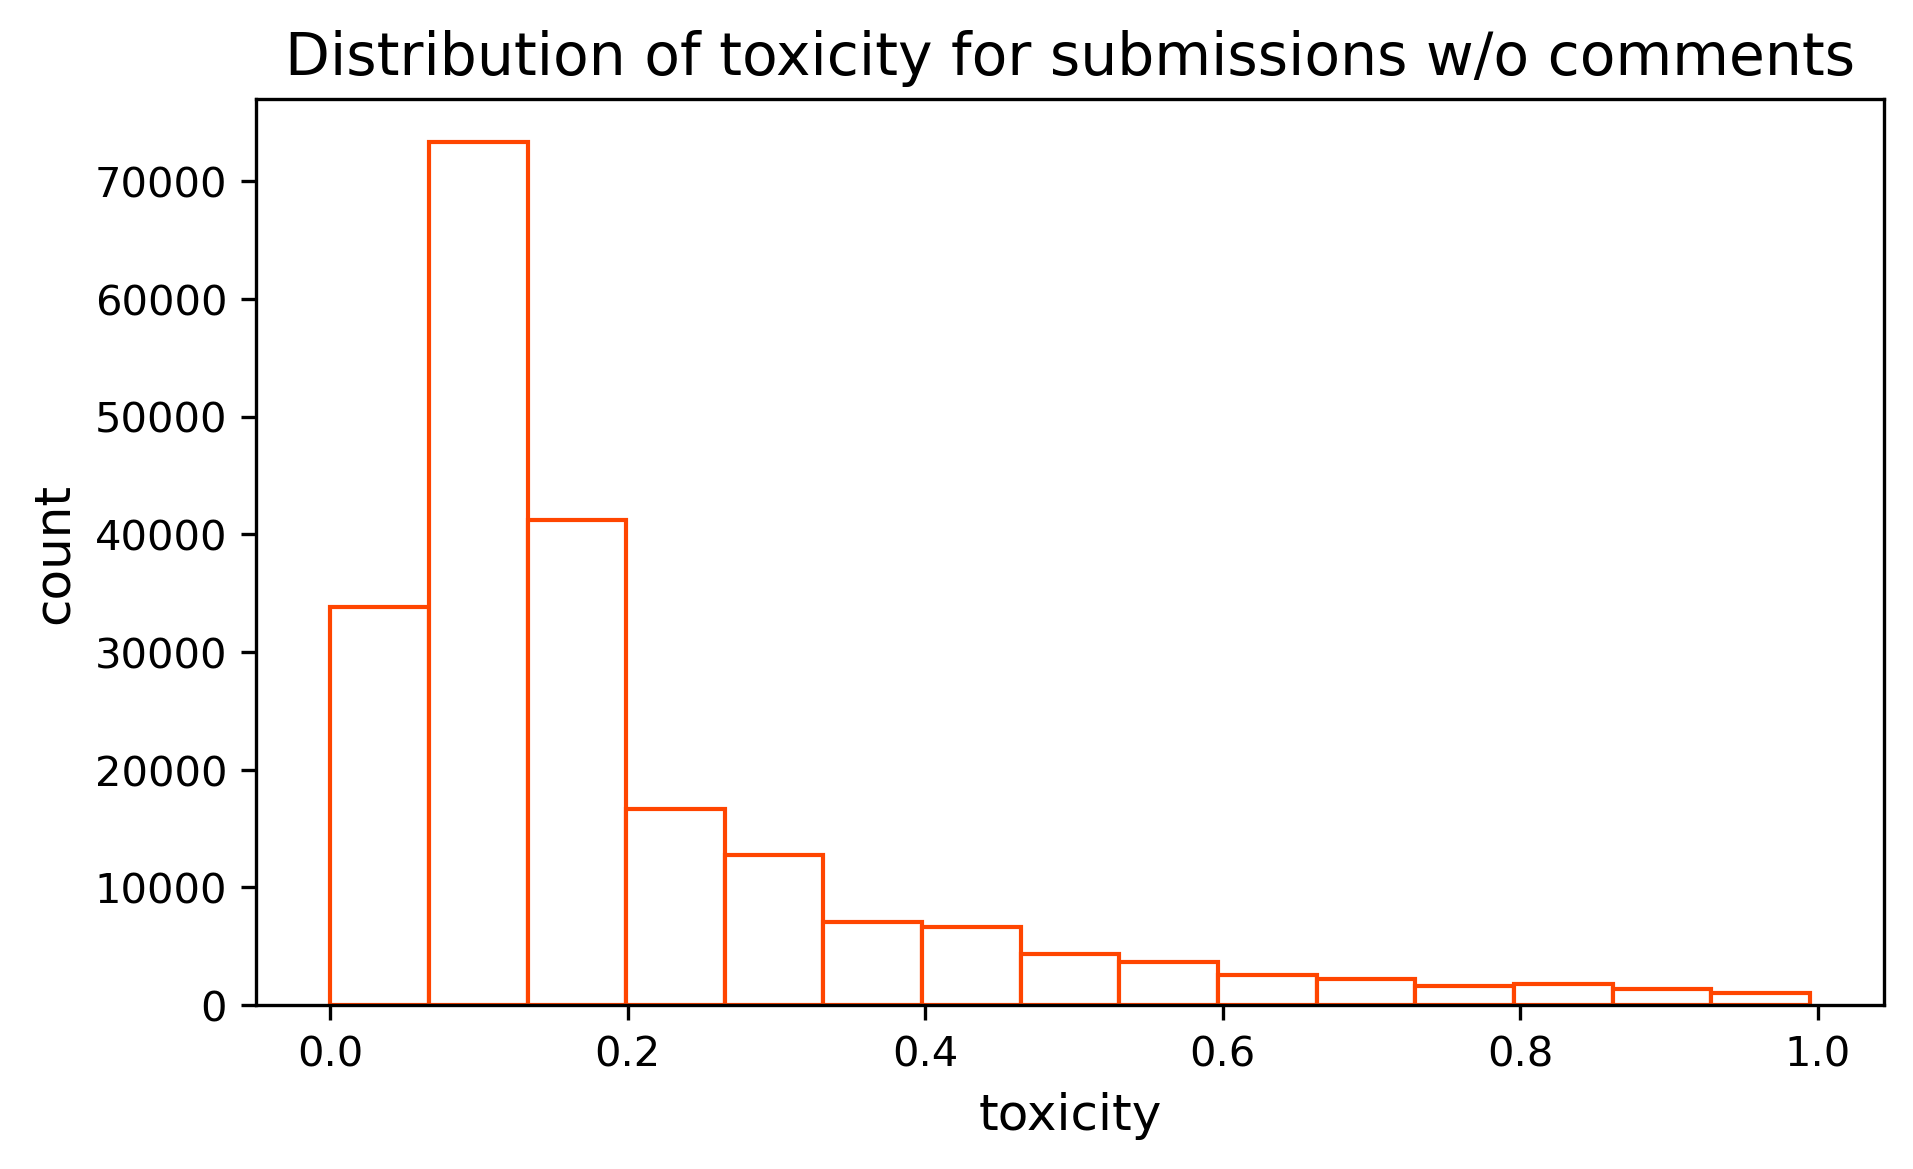

In [5]:
# toxicity score for submissions that have no comment
no_comment_subm = groupby_subm[groupby_subm["n_comments"]==1]
fig,ax = plt.subplots(figsize=(7,4),dpi=300)
plt.hist(no_comment_subm["toxicity"], bins=15, color="white", ec="#FF4500")
plt.xlabel("toxicity", fontsize=12)
plt.ylabel("count", fontsize=12)
plt.title("Distribution of toxicity for submissions w/o comments", fontsize=14)
plt.savefig(ROOTPATH + "output/fig/toxicity_distr_subm0comm.png", dpi=300)

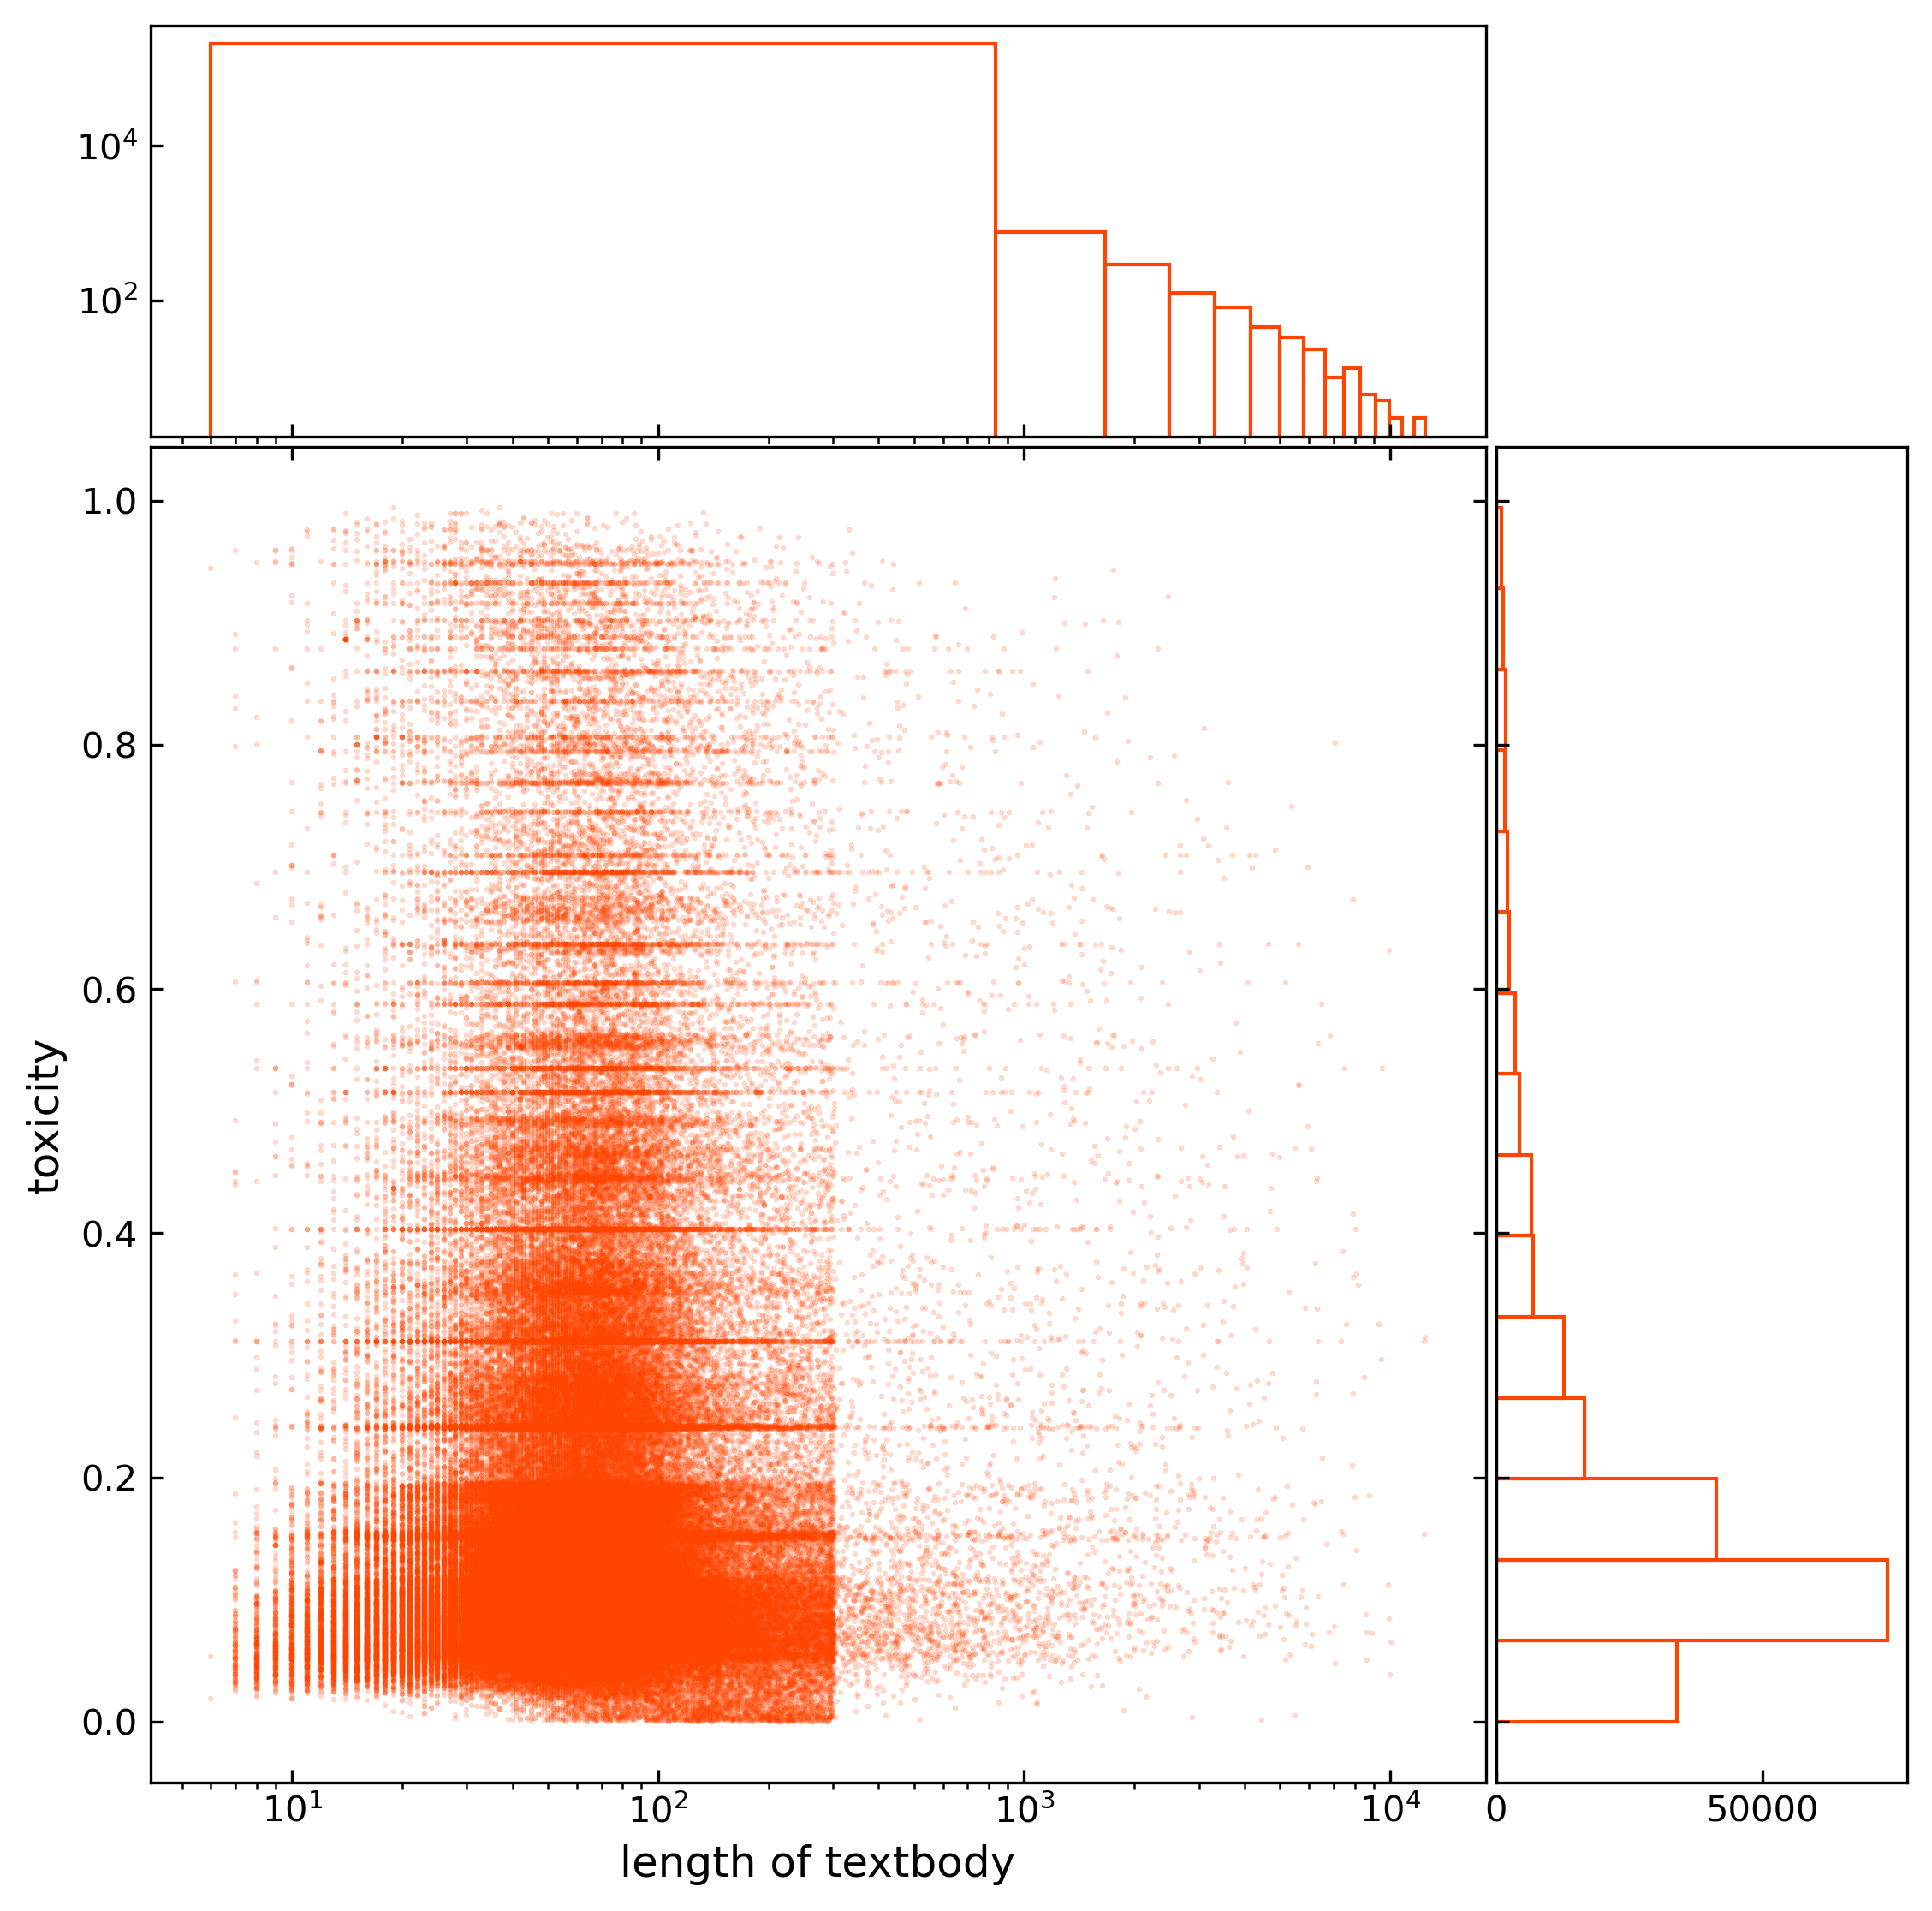

In [6]:
# docs: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

plotdf = no_comment_subm.dropna(subset=["toxicity"])
x = plotdf["body_len"]
y = plotdf["toxicity"]

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8,8), dpi=300)

# scatterplot
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction="in", top=True, right=True)
ax_scatter.set_xscale("log")
ax_scatter.scatter(x, y, color="#FF4500", marker="+", s=1, alpha=0.2)
ax_scatter.set_xlabel("length of textbody", fontsize=12)
ax_scatter.set_ylabel("toxicity", fontsize=12)

# histogram
ax_histx = plt.axes(rect_histx)
ax_histx.set_xscale("log")
ax_histx.set_yscale("log")
ax_histx.tick_params(direction="in", labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction="in", labelleft=False)
ax_histx.hist(x, bins=15, color="white", ec="#FF4500")
ax_histy.hist(y, orientation="horizontal", bins=15, color="white", ec="#FF4500")

plt.savefig(ROOTPATH + "output/fig/toxicity_length.png", dpi=300)

## build tree graphs

In [20]:
df2012_with_comm = df2012[["submission_id","comment_id", "parent_id"]].dropna()
aggr_func = {"comment_id":lambda x: list(x)}
groupby_subm = df2012_with_comm.groupby("submission_id").agg(aggr_func)
SUBM_COMM_DICT = groupby_subm.to_dict()["comment_id"]
COMM_PARENT_DICT = df2012_with_comm[["comment_id","parent_id"]].set_index("comment_id").to_dict()["parent_id"]

In [8]:
def build_tree_graph(subm):
    g = nx.Graph()
    comments = SUBM_COMM_DICT[subm]
    for comm in comments:
        its_parent = COMM_PARENT_DICT[comm][3:]
        g.add_edge(comm, its_parent)
    return g

In [9]:
ALL_SUBM = groupby_subm.index
SUBM_TREE_DICT = {}
for i,subm in enumerate(ALL_SUBM):
    if i%5000==0: print("progress:", i/len(ALL_SUBM))
    SUBM_TREE_DICT[subm] = build_tree_graph(subm)

progress: 0.0
progress: 0.019133116746451764
progress: 0.03826623349290353
progress: 0.05739935023935529
progress: 0.07653246698580705
progress: 0.09566558373225882
progress: 0.11479870047871057
progress: 0.13393181722516234
progress: 0.1530649339716141
progress: 0.17219805071806588
progress: 0.19133116746451764
progress: 0.2104642842109694
progress: 0.22959740095742115
progress: 0.24873051770387292
progress: 0.2678636344503247
progress: 0.2869967511967765
progress: 0.3061298679432282
progress: 0.32526298468967996
progress: 0.34439610143613175
progress: 0.3635292181825835
progress: 0.3826623349290353
progress: 0.401795451675487
progress: 0.4209285684219388
progress: 0.44006168516839056
progress: 0.4591948019148423
progress: 0.4783279186612941
progress: 0.49746103540774583
progress: 0.5165941521541976
progress: 0.5357272689006494
progress: 0.5548603856471012
progress: 0.573993502393553
progress: 0.5931266191400046
progress: 0.6122597358864564
progress: 0.6313928526329082
progress: 0.650

In [10]:
g = build_tree_graph("zzzw7")
pos = nx.spring_layout(g)

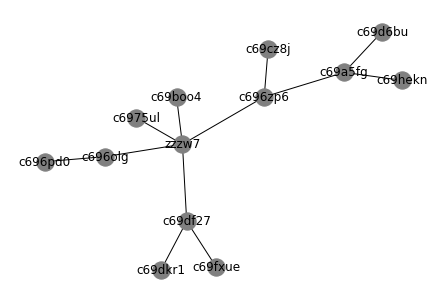

In [11]:
nx.draw(g, pos, with_labels=True, node_color="grey")

# calculate tree attributes

- toxicity level:
    - average toxicity
    - max toxicity

- engagement attributes:
    - tree-related:
        - average depth 
        - max depth of
        - number of branches
    - textual:
        - average text length
        - sum of text length
        - 
    - others:
        - number of unique users

In [13]:
# average toxicity per submission

In [22]:
aggr_func = {"toxicity": (np.max, np.mean),
             "body_len": (np.sum, np.mean),
             "author": set(x)}
groupby_subm = df2012.dropna(subset=["comment_id"]).groupby("submission_id").agg(aggr_func)

TypeError: 'int' object is not callable